# 6. Decision Trees and Ensemble Learning

decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

In [1]:


import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline




### 6.2 Data cleaning and preparation


In [2]:
df = pd.read_csv('../data/credit_scoring.csv')

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


In [6]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

# Could also use replace: `df.replace({'status': status_values, 'job': job_values})`

df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
df['income'].replace(to_replace=99999999, value=np.nan).max()


959.0

In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)


In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
# drop record with missing value for outcome variable
df = df[df.status != 'unk'].reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [17]:
del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decision trees

    How a decision tree looks like
    Training a decision tree
    Overfitting
    Controlling the size of a tree


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [19]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
# train_dicts[:5]

In [20]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [21]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6627533845147854

In [25]:
# AUC training
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [26]:
# control overfittring: restrict depth to 3
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
print('val: ', roc_auc_score(y_val, y_pred))

# AUC training
y_pred = dt.predict_proba(X_train)[:, 1]
print('train: ', roc_auc_score(y_train, y_pred))

val:  0.7389079944782155
train:  0.7761016984958594


In [27]:
from sklearn.tree import export_text

In [28]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0




# 6.5 Decision trees parameter tuning

* selecting max_depth
* selecting min_samples_leaf



In [29]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.753
  10 -> 0.702
  15 -> 0.659
  20 -> 0.656
None -> 0.649


In [30]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))


In [31]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [32]:
df_scores.sort_values(by = 'auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
19,6,15,0.785319
18,6,10,0.777803
22,6,100,0.776434
12,5,20,0.774028
20,6,20,0.773982


In [33]:
# index - row
df_scores_pivot = df_scores.pivot(
    index='min_samples_leaf', 
    columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.760
5                 0.761  0.768  0.761
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

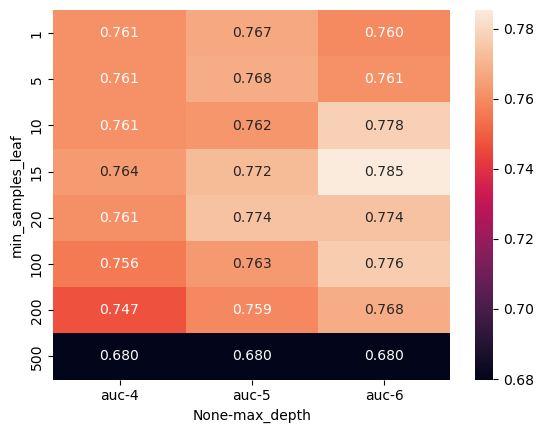

In [34]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [35]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None



## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest



In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)


In [38]:
auc

0.7744726453706618

In [39]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))



In [40]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

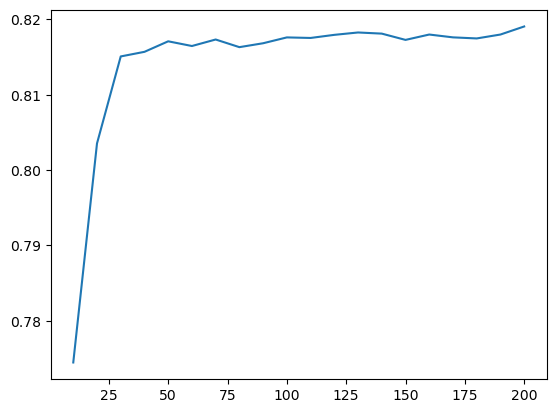

In [41]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [42]:
# Include parameter 'max depth'
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))



In [43]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)


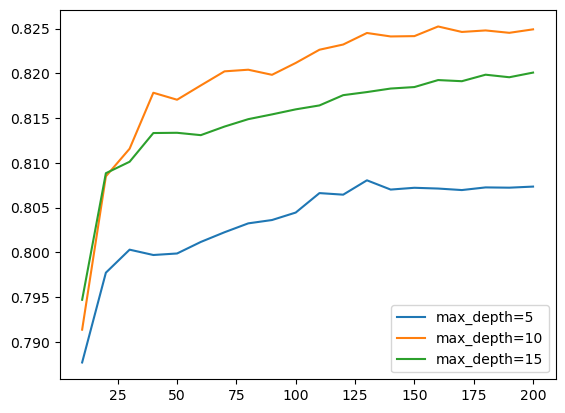

In [44]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [45]:
# split point at any depth will only be considered if it leaves at 
# least the minimum number of samples required in each branch.
max_depth = 10

scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [46]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

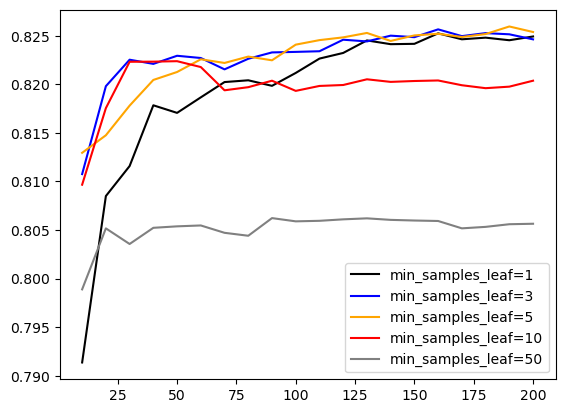

In [47]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [48]:
# retrain using best parameters:
#  -- max-depth = 10
#  -- min-value leaf = 3
#  -- 100 trees
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            min_samples_leaf=2,
                            random_state=1)
rf.fit(X_train, y_train)


 

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 6.7 Gradient boosting and XGBoost
* Gradient boosting vs random forest  
* Installing XGBoost  
* Training the first model  
* Performance monitoring  
* Parsing xgboost's monitoring output  

In [49]:
import xgboost as xgb

In [50]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)



In [51]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [52]:
y_pred = model.predict(dval)

In [53]:
roc_auc_score(y_val, y_pred)

0.8118506454190986

In [ ]:
# capture model progress over training
watchlist = [(dtrain, 'train'), (dval, 'val')]
evals_result = {}

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100, evals_result = evals_result)

[0]	train-auc:0.86653	val-auc:0.77999
[1]	train-auc:0.89089	val-auc:0.79060
[2]	train-auc:0.90503	val-auc:0.78881
[3]	train-auc:0.91573	val-auc:0.79997
[4]	train-auc:0.92429	val-auc:0.80367
[5]	train-auc:0.92969	val-auc:0.80822
[6]	train-auc:0.93630	val-auc:0.81043
[7]	train-auc:0.94073	val-auc:0.81173
[8]	train-auc:0.94748	val-auc:0.81328
[9]	train-auc:0.95012	val-auc:0.81185
[10]	train-auc:0.95512	val-auc:0.81115
[11]	train-auc:0.95661	val-auc:0.81133
[12]	train-auc:0.95936	val-auc:0.81433
[13]	train-auc:0.96146	val-auc:0.81863
[14]	train-auc:0.96427	val-auc:0.81872
[15]	train-auc:0.96767	val-auc:0.81993
[16]	train-auc:0.96975	val-auc:0.81863
[17]	train-auc:0.97158	val-auc:0.82002
[18]	train-auc:0.97336	val-auc:0.82015
[19]	train-auc:0.97499	val-auc:0.81979
[20]	train-auc:0.97648	val-auc:0.81877
[21]	train-auc:0.97773	val-auc:0.81969
[22]	train-auc:0.97842	val-auc:0.81880
[23]	train-auc:0.97902	val-auc:0.81805
[24]	train-auc:0.98102	val-auc:0.81686
[25]	train-auc:0.98248	val-auc:0.81

In [115]:
# Access the evaluation results
def parse_xgb_output(output):

    columns = ['train_auc', 'val_auc']

    df_score_train = pd.DataFrame(output['train']['auc'])
    df_score_val = pd.DataFrame(output['val']['auc'])
    
    df_score = pd.concat([df_score_train, df_score_val], axis = 1,)
    df_score.columns = columns

    df_score['num_iter'] = df_score.reset_index().index + 1
    return df_score

In [116]:
df_score = parse_xgb_output(evals_result)

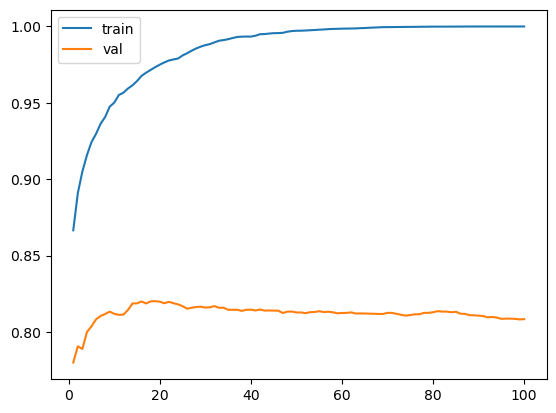

In [117]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()


# 6.8 XGBoost parameter tuning  
  
Tuning the following parameters:  
  
* eta  
* max_depth  
* min_child_weight  



In [113]:
scores = {}

In [118]:
'eta=%s' % (xgb_params['eta'])


'eta=0.3'

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(evals_result)
key


'eta=0.3'

In [124]:
scores

{'eta=0.3':     train_auc   val_auc  num_iter
 0    0.866526  0.779991         1
 1    0.890891  0.790599         2
 2    0.905030  0.788807         3
 3    0.915726  0.799965         4
 4    0.924286  0.803668         5
 ..        ...       ...       ...
 95   0.999992  0.808714        96
 96   0.999992  0.808690        97
 97   0.999993  0.808557        98
 98   0.999993  0.808176        99
 99   0.999994  0.808375       100
 
 [100 rows x 3 columns]}

In [ ]:
# re-run mulitple across parameters:
#  -- 'eta' values [eta=0.3', 'eta=1', 'eta=0.1'*, 'eta=0.01']
#  -- 'max_depth [6, 3*, 4, 10]
#  -- 'min_child_weight' [1*, 10, 30]
# * is best
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100, evals_result = evals_result)
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(evals_result)

[0]	train-auc:0.76455	val-auc:0.73369
[1]	train-auc:0.79975	val-auc:0.76811
[2]	train-auc:0.80903	val-auc:0.76857
[3]	train-auc:0.81792	val-auc:0.76872
[4]	train-auc:0.81992	val-auc:0.77119
[5]	train-auc:0.82726	val-auc:0.77541
[6]	train-auc:0.83189	val-auc:0.77756
[7]	train-auc:0.83539	val-auc:0.78187
[8]	train-auc:0.84052	val-auc:0.79222
[9]	train-auc:0.84374	val-auc:0.79428
[10]	train-auc:0.84502	val-auc:0.79427
[11]	train-auc:0.84560	val-auc:0.79542
[12]	train-auc:0.84753	val-auc:0.79610
[13]	train-auc:0.84952	val-auc:0.79791
[14]	train-auc:0.85223	val-auc:0.80266
[15]	train-auc:0.85474	val-auc:0.80435
[16]	train-auc:0.85516	val-auc:0.80419
[17]	train-auc:0.85697	val-auc:0.80566
[18]	train-auc:0.85944	val-auc:0.80822
[19]	train-auc:0.86122	val-auc:0.81016
[20]	train-auc:0.86152	val-auc:0.81053
[21]	train-auc:0.86284	val-auc:0.81013
[22]	train-auc:0.86472	val-auc:0.81263
[23]	train-auc:0.86578	val-auc:0.81400
[24]	train-auc:0.86741	val-auc:0.81575
[25]	train-auc:0.86732	val-auc:0.81

In [156]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

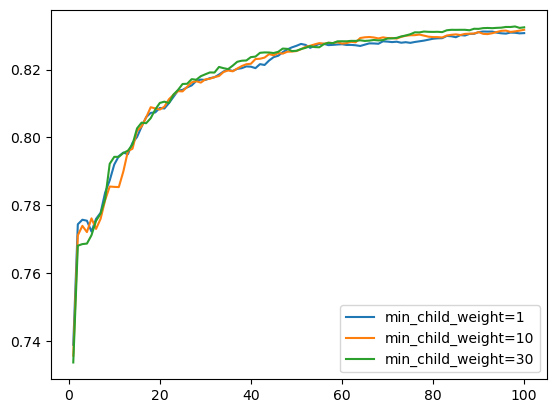

In [157]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

#plt.ylim(0.8, 0.84)
plt.legend()


In [151]:
# reset key for above to compare parameter(s) {max_depth, }
scores = {}

In [158]:
# final model
gb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)


### 6.9 Select best model

In [159]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [160]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7856948245380349

In [161]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [162]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [163]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [164]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8334715797631446

In [165]:
# Training the final model
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']


In [166]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [ ]:
dfulltrain = xgb.DMatrix(
    X_full_train, label=y_full_train,
    feature_names = list(dv.get_feature_names_out()))
dv.get_feature_names_out()
# test does not need lables, as evaluation will carried out with scikit-learn
dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))


In [171]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [172]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8299814280826938